In [17]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#read the data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

data_path = "/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/"
train = pd.read_table(os.path.join(data_path,"translated/'ttrain.tsv'.txt"),parse_dates=["datetime"], date_parser = dateparse)
test = pd.read_table(os.path.join(data_path,"translated/'ttest.tsv'.txt"),parse_dates=["datetime"], date_parser = dateparse)


In [180]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 8))
    orig = plt.plot(timeseries,label='Original',linewidth=2.0)
    mean = plt.plot(rolmean, label='Rolling Mean',linewidth=2.0)
    std = plt.plot(rolstd, label = 'Rolling Std',linewidth=2.0)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [53]:
nikko_train = pd.read_table(os.path.join(data_path,"ProcessedData/nikko_Dataset.csv"),parse_dates=["datetime"], date_parser = dateparse)
nikko_train.index = nikko_train["datetime"]
nikko_train = nikko_train.drop(["datetime", "epark","Unnamed: 0"], axis =1)


In [116]:
nikko_test = pd.read_table(os.path.join(data_path,"ProcessedData/Test/nikko_test_weather.csv"),parse_dates=["datetime"], date_parser = dateparse)
nikko_test.index = nikko_test["datetime"]

In [100]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
coint_johansen(nikko_train.fillna(0),-1,1).eig

array([3.19214130e-01, 3.04140006e-01, 2.52971797e-01, 2.00243433e-01,
       1.11186996e-01, 6.20298136e-02, 1.46727492e-02, 4.66066962e-06])

In [132]:
nikko_tvis = nikko_train["visitors"]
nikko_tvis.index = nikko_train.index


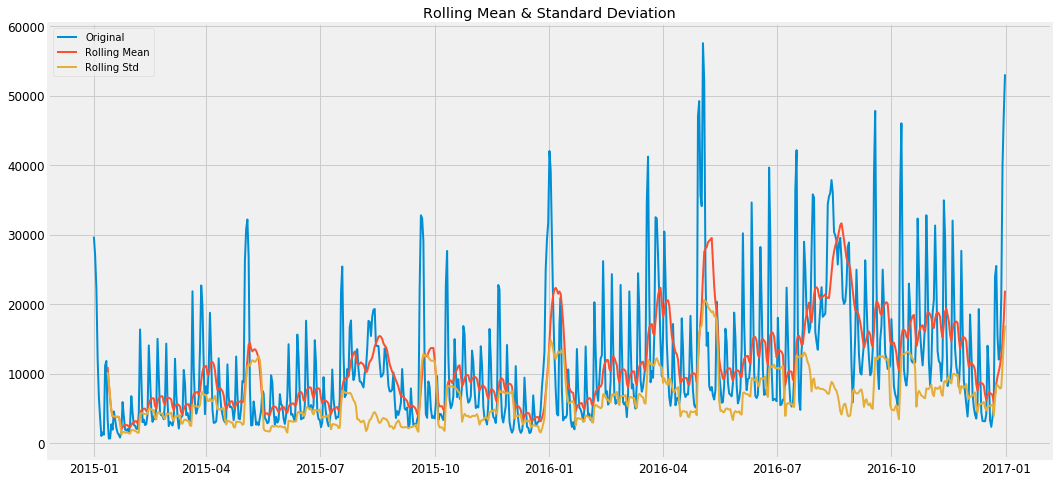

Results of Dickey-Fuller Test:
Test Statistic                  -3.155866
p-value                          0.022686
#Lags Used                      19.000000
Number of Observations Used    711.000000
Critical Value (1%)             -3.439581
Critical Value (5%)             -2.865614
Critical Value (10%)            -2.568939
dtype: float64


In [181]:
test_stationarity(nikko_tvis)

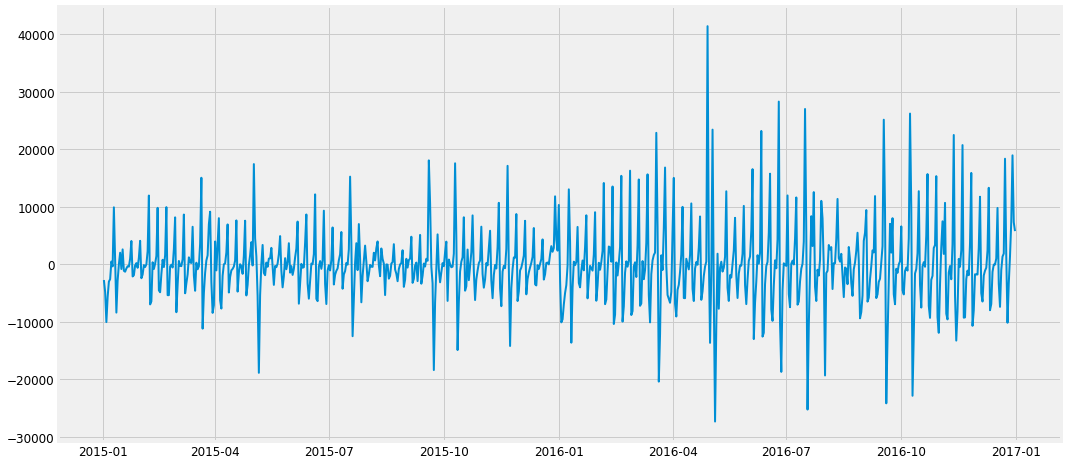

In [217]:
#differencing
plt.figure(figsize=[16,8])
nikko_tvis_diff = nikko_tvis - nikko_tvis.shift()
plt.plot(nikko_tvis_diff,linewidth=2.0)

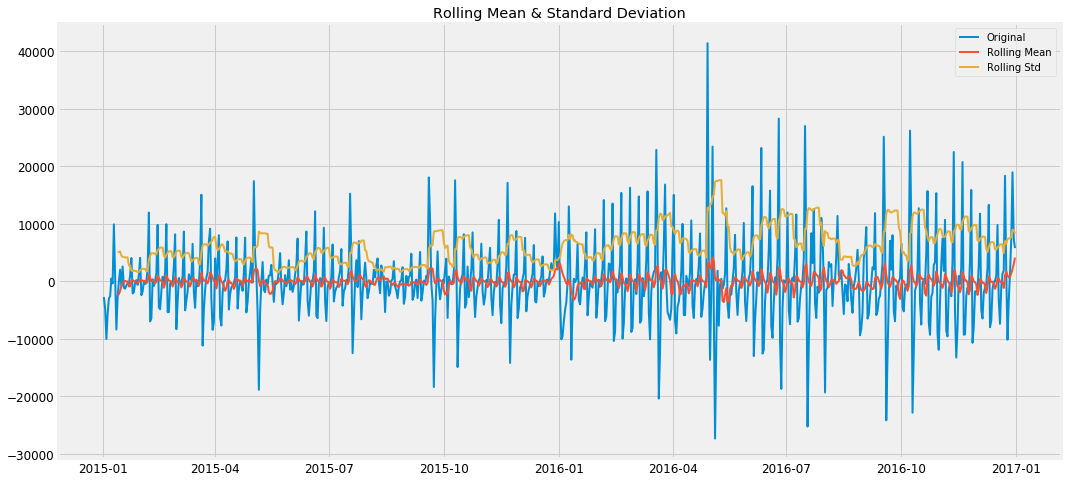

Results of Dickey-Fuller Test:
Test Statistic                -7.025913e+00
p-value                        6.365475e-10
#Lags Used                     2.000000e+01
Number of Observations Used    7.090000e+02
Critical Value (1%)           -3.439607e+00
Critical Value (5%)           -2.865625e+00
Critical Value (10%)          -2.568945e+00
dtype: float64


In [218]:
nikko_tvis_diff.dropna(inplace=True)
test_stationarity(nikko_tvis_diff)

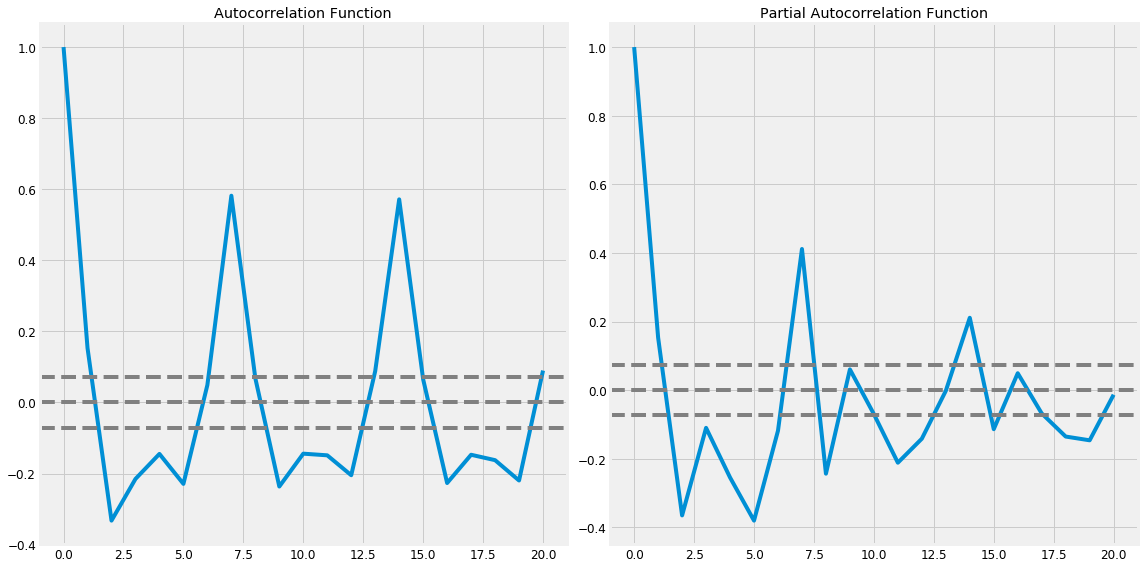

In [219]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(nikko_tvis_diff, nlags=20)
lag_pacf = pacf(nikko_tvis_diff, nlags=20, method='ols')


#Plot ACF: 
plt.figure(figsize=[16,8])
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(nikko_tvis_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(nikko_tvis_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(nikko_tvis_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(nikko_tvis_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'MAE: 4316.5305')

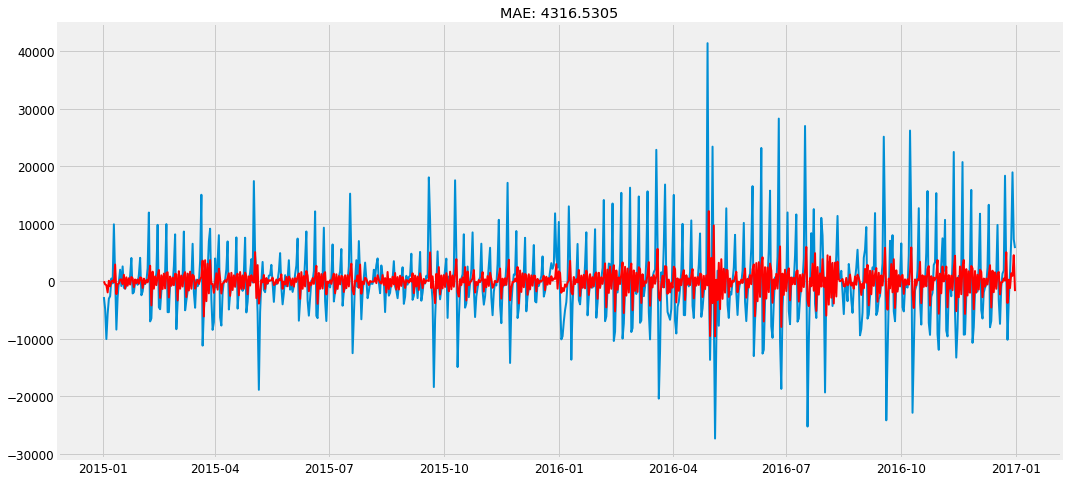

In [220]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(nikko_tvis_diff, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  

plt.figure(figsize=[16,8])
plt.plot(nikko_tvis_diff,linewidth=2.0)
plt.plot(results_ARIMA.fittedvalues, color='red', linewidth=2.0)
plt.title('MAE: %.4f'% np.mean(np.abs(results_ARIMA.fittedvalues-nikko_tvis_diff)))

In [221]:
#BACK TO ORIGINAL SCALE
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

datetime
2015-01-02      31.987669
2015-01-03    -505.724687
2015-01-04    -637.798042
2015-01-05   -1897.022963
2015-01-06     122.742042
dtype: float64


In [222]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

datetime
2015-01-02      31.987669
2015-01-03    -473.737018
2015-01-04   -1111.535060
2015-01-05   -3008.558024
2015-01-06   -2885.815982
dtype: float64


In [211]:
predictions_ARIMA_log = pd.Series(nikko_tvis.ix[0], index=nikko_tvis.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log

datetime
2015-01-01     29714.000000
2015-01-02     29714.000000
2015-01-03     29714.000000
2015-01-04     29714.000000
2015-01-05     29714.000000
2015-01-06     29714.000000
2015-01-07     29714.000000
2015-01-08     29851.682379
2015-01-09      7942.228284
2015-01-10     -9778.980969
2015-01-11    -14657.731717
2015-01-12    -13763.028748
2015-01-13    -15280.249767
2015-01-14    -12365.957238
2015-01-15    -10666.558145
2015-01-16    -11326.479017
2015-01-17    -13262.221663
2015-01-18    -22385.997516
2015-01-19    -27438.816076
2015-01-20    -25306.234066
2015-01-21    -24985.001583
2015-01-22    -22875.649746
2015-01-23    -23975.268112
2015-01-24    -23507.275017
2015-01-25    -23652.876874
2015-01-26    -25302.689165
2015-01-27    -24971.892810
2015-01-28    -23718.465997
2015-01-29    -21948.342841
2015-01-30    -20974.529654
                  ...      
2016-12-02     47311.280308
2016-12-03     43629.203570
2016-12-04     35587.655386
2016-12-05     34724.370457
2016-12-06 

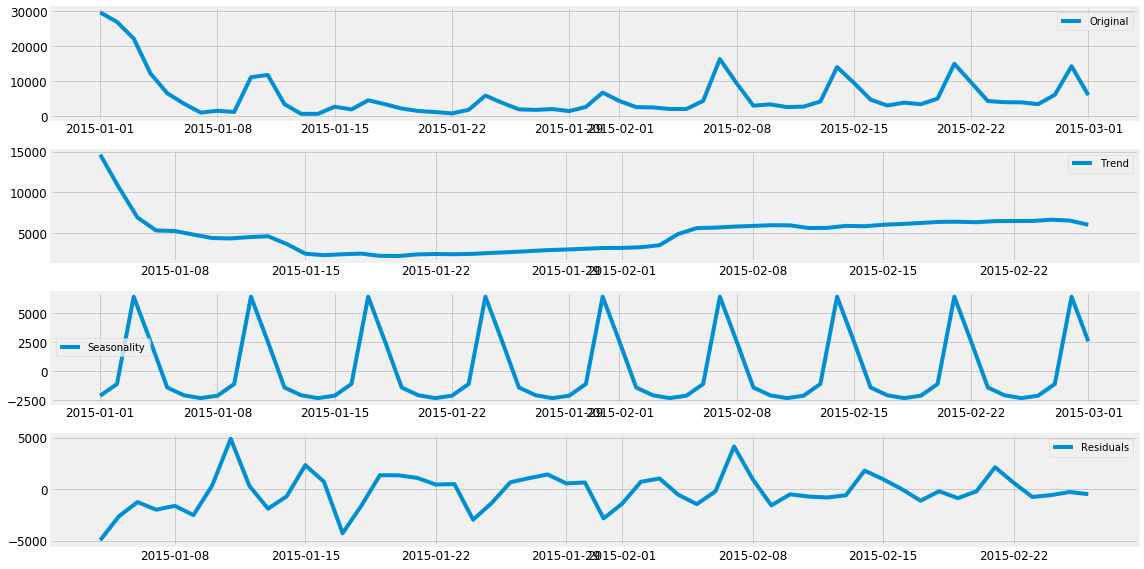

In [160]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(nikko_tvis[:'2015-03-01'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=[16,8])
plt.subplot(411)
plt.plot(nikko_tvis[:'2015-03-01'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

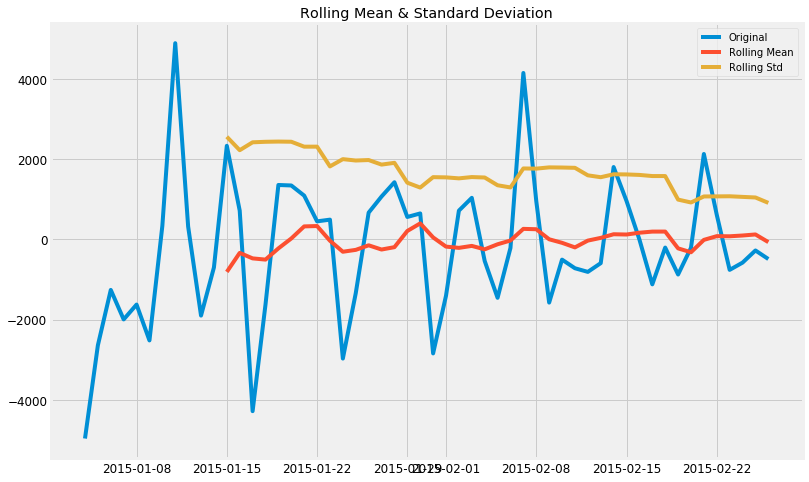

Results of Dickey-Fuller Test:
Test Statistic                 -5.099077
p-value                         0.000014
#Lags Used                      8.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [161]:
nikko_tvis_decompose = residual
nikko_tvis_decompose.dropna(inplace=True)
test_stationarity(nikko_tvis_decompose)

In [124]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset

# fit model
model = SARIMAX(nikko_train["visitors"], order=(1, 1, 1), seasonal_order=(1,1,1,1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(start = len(nikko_train["visitors"]), end= len(nikko_train["visitors"])+365, dynamic= True)
print(yhat)

/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2017-01-01    43641.643712
2017-01-02    34030.203169
2017-01-03    27311.352572
2017-01-04    23224.219676
2017-01-05    20915.541813
2017-01-06    19672.607613
2017-01-07    19027.835959
2017-01-08    18705.208306
2017-01-09    18551.208156
2017-01-10    18483.660642
2017-01-11    18459.738542
2017-01-12    18457.557041
2017-01-13    18466.100945
2017-01-14    18479.892114
2017-01-15    18496.232528
2017-01-16    18513.804065
2017-01-17    18531.967110
2017-01-18    18550.413084
2017-01-19    18568.993858
2017-01-20    18587.638634
2017-01-21    18606.313703
2017-01-22    18625.003070
2017-01-23    18643.699170
2017-01-24    18662.398432
2017-01-25    18681.099176
2017-01-26    18699.800614
2017-01-27    18718.502376
2017-01-28    18737.204289
2017-01-29    18755.906272
2017-01-30    18774.608288
                  ...     
2017-12-03    24516.135890
2017-12-04    24534.837935
2017-12-05    24553.539979
2017-12-06    24572.242024
2017-12-07    24590.944068
2017-12-08    24609.646112
2

In [121]:
len(test[test["epark"]=="Nikko National Park"])

365

In [103]:
aa.cvm

array([[45.893 , 48.8795, 55.0335],
       [39.9085, 42.7679, 48.6606],
       [33.9271, 36.6301, 42.2333],
       [27.916 , 30.4428, 35.7359],
       [21.837 , 24.1592, 29.0609],
       [15.7175, 17.7961, 22.2519],
       [ 9.4748, 11.2246, 15.0923],
       [ 2.9762,  4.1296,  6.9406]])

In [102]:
aa.cvt

array([[137.9954, 143.6691, 154.7977],
       [106.7351, 111.7797, 121.7375],
       [ 79.5329,  83.9383,  92.7136],
       [ 56.2839,  60.0627,  67.6367],
       [ 37.0339,  40.1749,  46.5716],
       [ 21.7781,  24.2761,  29.5147],
       [ 10.4741,  12.3212,  16.364 ],
       [  2.9762,   4.1296,   6.9406]])

In [101]:
aa = coint_johansen(nikko_train.fillna(0),-1,1)

In [75]:
np.mean(prediction)

1575.4106465487412

In [72]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=365)
np.mean(prediction[:,0])

In [95]:
type(prediction)

numpy.ndarray

11631.909305992212

In [56]:
xx.cvm

array([[45.893 , 48.8795, 55.0335],
       [39.9085, 42.7679, 48.6606],
       [33.9271, 36.6301, 42.2333],
       [27.916 , 30.4428, 35.7359],
       [21.837 , 24.1592, 29.0609],
       [15.7175, 17.7961, 22.2519],
       [ 9.4748, 11.2246, 15.0923],
       [ 2.9762,  4.1296,  6.9406]])

In [57]:
xx.cvt

array([[137.9954, 143.6691, 154.7977],
       [106.7351, 111.7797, 121.7375],
       [ 79.5329,  83.9383,  92.7136],
       [ 56.2839,  60.0627,  67.6367],
       [ 37.0339,  40.1749,  46.5716],
       [ 21.7781,  24.2761,  29.5147],
       [ 10.4741,  12.3212,  16.364 ],
       [  2.9762,   4.1296,   6.9406]])

In [66]:
nikko_train.head()

,visitors,Average temperature (℃),Total precipitation (mm),Total snowfall (cm),Average wind speed (m/s),Average vapor pressure (hPa),Average local atmospheric pressure (hPa),Average humidity (%)
datetime,,,,,,,,
2015-01-01,29714,-7.4,0.0,3.0,6.1,2.1,852.5,61.0
2015-01-02,27011,-7.1,0.0,1.0,3.8,2.2,858.6,62.0
2015-01-03,22247,-7.0,0.5,2.0,6.3,2.4,862.2,67.0
2015-01-04,12236,-2.3,0.0,0.0,2.1,3.6,863.8,69.0
2015-01-05,6571,-1.1,0.0,1.0,2.8,4.0,868.1,71.0
